In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from collections import Counter
import spacy
import tqdm as tqdm
import string
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import numpy as np

import ignite
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

In [ ]:
#https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130

In [ ]:
#import data
dataset = pd.read_csv(r'./SentimentAnalysisDataset.csv', error_bad_lines=False)



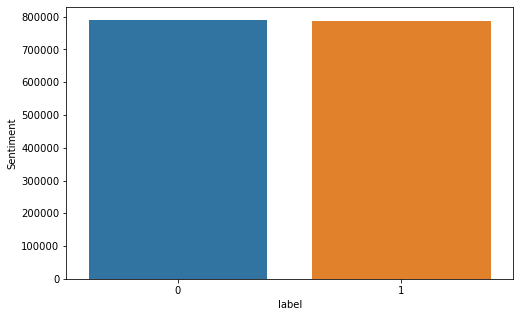

In [3]:
#plot data 
figure = plt.figure(figsize=(8,5))
ax = sns.barplot(x = dataset.Sentiment.unique(), y = dataset.Sentiment.value_counts())
ax.set(xlabel='label')
plt.show()

In [4]:
dataset.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [5]:
dataset.shape

(1578612, 4)

In [6]:
#remove trailing and leading spaces
dataset['SentmentText'] = dataset['SentimentText'].apply(lambda x: x.strip())

In [7]:
#Load Spacy Tokenizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

In [16]:
#There is an even split 
#Now create bag of words with all the data in the tweets 
#this is also called tokenizing the data 
#We create an index mapping dict where the most common words have low indexes
#can use Counter from Collections


words = Counter()
punct = '!#$%&()\'\'\"\"*+,-./:;<=>?@[\]^_`{|}~'
for i in tqdm.tqdm(dataset['SentimentText'].values):
    i = i.strip()
    #i= i.strip(punct)
    i.translate(str.maketrans('','',string.punctuation))
    i = nlp(i)
    words.update(i)
    #words.update(i.lower() for i in nlp(i))
    #words.update(x.lower() for x in nlp(i))


100%|███████████████████████████████████████████| 1578612/1578612 [10:52<00:00, 2418.01it/s]


In [17]:
#Sort so most frequent woccur first
words = sorted(words, key = words.get, reverse=True)

In [23]:
# add <pad> and <unk> token to vocab which will be used later
words = ['_PAD','_UNK'] + words

In [24]:
words

['_PAD',
 '_UNK',
 is,
 so,
 sad,
 for,
 my,
 APL,
 friend,
 .............,
 I,
 missed,
 the,
 New,
 Moon,
 trailer,
 ...,
 omg,
 its,
 already,
 7:30,
 :O,
 ..,
 Omgaga,
 .,
 I,
 m,
 sooo,
  ,
 i,
 m,
 gunna,
 CRy,
 .,
 I,
 've,
 been,
 at,
 this,
 dentist,
 since,
 11,
 ..,
 I,
 was,
 suposed,
 2,
 just,
 get,
 a,
 crown,
 put,
 on,
 (,
 30mins,
 ),
 ...,
 i,
 think,
 mi,
 bf,
 is,
 cheating,
 on,
 me,
 !,
 !,
 !,
       ,
 T_T,
 or,
 i,
 just,
 worry,
 too,
 much,
 ?,
 Juuuuuuuuuuuuuuuuussssst,
 Chillin,
 !,
 !,
 Sunny,
 Again,
        ,
 Work,
 Tomorrow,
  ,
 :-|,
       ,
 TV,
 Tonight,
 handed,
 in,
 my,
 uniform,
 today,
 .,
 i,
 miss,
 you,
 already,
 hmmmm,
 ....,
 i,
 wonder,
 how,
 she,
 my,
 number,
 @-,
 ),
 I,
 must,
 think,
 about,
 positive,
 ..,
 thanks,
 to,
 all,
 the,
 haters,
 up,
 in,
 my,
 face,
 all,
 day,
 !,
 112,
 -,
 102,
 this,
 weekend,
 has,
 sucked,
 so,
 far,
 jb,
 is,
 nt,
 showing,
 in,
 australia,
 any,
 more,
 !,
 ok,
 that,
 s,
 it,
 you,
 win,
 .

In [25]:
#Create word to index dict
word2index = {k:v for v,k in enumerate(words)}
index2words = {i:o for i, o in enumerate(words)}

In [26]:
word2index

{'_PAD': 0,
 '_UNK': 1,
 is: 2,
 so: 3,
 sad: 4,
 for: 5,
 my: 6,
 APL: 7,
 friend: 8,
 .............: 9,
 I: 10,
 missed: 11,
 the: 12,
 New: 13,
 Moon: 14,
 trailer: 15,
 ...: 16,
 omg: 17,
 its: 18,
 already: 19,
 7:30: 20,
 :O: 21,
 ..: 22,
 Omgaga: 23,
 .: 24,
 I: 25,
 m: 26,
 sooo: 27,
  : 28,
 i: 29,
 m: 30,
 gunna: 31,
 CRy: 32,
 .: 33,
 I: 34,
 've: 35,
 been: 36,
 at: 37,
 this: 38,
 dentist: 39,
 since: 40,
 11: 41,
 ..: 42,
 I: 43,
 was: 44,
 suposed: 45,
 2: 46,
 just: 47,
 get: 48,
 a: 49,
 crown: 50,
 put: 51,
 on: 52,
 (: 53,
 30mins: 54,
 ): 55,
 ...: 56,
 i: 57,
 think: 58,
 mi: 59,
 bf: 60,
 is: 61,
 cheating: 62,
 on: 63,
 me: 64,
 !: 65,
 !: 66,
 !: 67,
       : 68,
 T_T: 69,
 or: 70,
 i: 71,
 just: 72,
 worry: 73,
 too: 74,
 much: 75,
 ?: 76,
 Juuuuuuuuuuuuuuuuussssst: 77,
 Chillin: 78,
 !: 79,
 !: 80,
 Sunny: 81,
 Again: 82,
        : 83,
 Work: 84,
 Tomorrow: 85,
  : 86,
 :-|: 87,
       : 88,
 TV: 89,
 Tonight: 90,
 handed: 91,
 in: 92,
 my: 93,
 uniform: 94,
 

In [47]:
#Create function that indexes
def indexer(x):
    for w in nlp(x):
        if w in word2index:
            return word2index[w.lower()]
        else: 
            return None
    #return [word2index.get(w.lower) for w in nlp(x)]

In [48]:
#Tokenize tweets and calculate lengths of each tweet
dataset['SentimentIndex'] = dataset['SentimentText'].apply(indexer)


In [49]:
def lengths(x):
    try:
        len(x)
    except:
        return 0
   
        

In [50]:
dataset['SentimentIndex']

0          None
1          None
2          None
3          None
4          None
           ... 
1578607    None
1578608    None
1578609    None
1578610    None
1578611    None
Name: SentimentIndex, Length: 1578612, dtype: object

In [51]:
dataset['Lengths'] = dataset['SentimentIndex'].astype('int64').apply(len)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = sns.distplot(dataset['Lengths'].values, kde=False)
ax.set(xlabel='Tweet Length', ylabel = 'Freq')

In [ ]:
dataset.head()

In [52]:
df = pd.read_csv(r'./SentimentAnalysisDataset.csv', error_bad_lines=False)


b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


Progress: 100%|███████████████████████████████| 1578612/1578612 [00:03<00:00, 416044.80it/s]


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Tweet Length')]

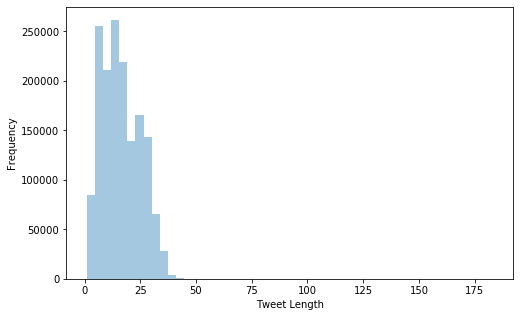

In [54]:
# all imports
from collections import Counter
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

# load spacy tokenizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])
# df.progress_apply is tqdm method for pandas. It shows progress bar for apply function
# remove the leading and trailing spaces
df['SentimentText'] = df.SentimentText.progress_apply(lambda x: x.strip())

# build vocabulary and corresponding counts
words = Counter()
for sent in tqdm(df.SentimentText.values):
    words.update(w.text.lower() for w in nlp(sent))
   
# sort with most frequently occuring words first
words = sorted(words, key=words.get, reverse=True)
# add <pad> and <unk> token to vocab which will be used later
words = ['_PAD','_UNK'] + words

# create word to index dictionary and reverse
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

def indexer(s): 
  return [word2idx[w.text.lower()] for w in nlp(s)]

# tokenize the tweets and calculate lengths
df['sentimentidx'] = df.SentimentText.progress_apply(indexer)
df['lengths'] = df.sentimentidx.progress_apply(len)

fig = plt.figure(figsize=(8,5))
ax = sns.distplot(df.lengths.values,kde=False);
ax.set(xlabel='Tweet Length', ylabel='Frequency')

In [55]:
df.head()

,ItemID,Sentiment,SentimentSource,SentimentText,sentimentidx,lengths
0,1,0,Sentiment140,is so sad for my APL friend.............,"[14, 26, 132, 18, 10, 241470, 266, 6618]",8
1,2,0,Sentiment140,I missed the New Moon trailer...,"[2, 272, 7, 91, 812, 1274, 16]",7
2,3,1,Sentiment140,omg its already 7:30 :O,"[247, 82, 217, 4572, 1012]",5
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I've been at...,"[37, 241471, 4, 2, 73, 440, 6, 2, 73, 1453, 55...",35
4,5,0,Sentiment140,i think mi bf is cheating on me!!! T_T,"[2, 93, 1813, 1342, 14, 5541, 23, 24, 3, 3, 3,...",13


In [56]:
# Now create pytorch dataset and dataloader

# subclass the custom dataset class with torch.utils.data.Dataset
# implement __len__ and __getitem__ function
class VectorizeData(Dataset):
    def __init__(self, df_path):
        self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df['SentimentText'] = self.df.SentimentText.apply(lambda x: x.strip())
        self.df['sentimentidx'] = self.df.SentimentText.apply(indexer)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        x = self.df.sentimentidx[idx]
        y = self.df.Sentiment[idx]
        return x,y
      


In [57]:
# create instance of custom dataset
ds = VectorizeData('./SentimentAnalysisDataset.csv')
# get first 4 samples
print(ds[:4])

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


(0             [14, 26, 132, 18, 10, 241470, 266, 6618]
1                       [2, 272, 7, 91, 812, 1274, 16]
2                           [247, 82, 217, 4572, 1012]
3    [37, 241471, 4, 2, 73, 440, 6, 2, 73, 1453, 55...
Name: sentimentidx, dtype: object, 0    0
1    0
2    1
3    0
Name: Sentiment, dtype: int64)


In [58]:
#We'll use the pytorch Dataload so we can use the custom data set above


dl = DataLoader(dataset=ds, batch_size=3)
print('Total Samples ', len(dl))

it = iter(dl)
xs, ys = next(it)
print('Length of smallest tweet', len(xs))
print(type(xs))
print(xs)


Total Samples  526204
Length of smallest tweet 5
<class 'list'>
[tensor([ 14,   2, 247]), tensor([ 26, 272,  82]), tensor([132,   7, 217]), tensor([  18,   91, 4572]), tensor([  10,  812, 1012])]


In [62]:
#Pad the data set and calculate lengths of tweets
#any tweet shorter than 10 is padded with zeros 
class VectorizeData(Dataset):
    def __init__(self, df_path, maxlen=10):
        self.maxlen = maxlen
        self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df['SentimentText'] = self.df.SentimentText.apply(lambda x: x.strip())
        print('Indexing...')
        self.df['sentimentidx'] = self.df.SentimentText.progress_apply(indexer)
        print('Calculating lengths')
        self.df['lengths'] = self.df.sentimentidx.progress_apply(lambda x: self.maxlen if len(x) > self.maxlen else len(x))
        print('Padding')
        self.df['sentimentpadded'] = self.df.sentimentidx.progress_apply(self.pad_data)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.sentimentpadded[idx]
        lens = self.df.lengths[idx]
        y = self.df.Sentiment[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded
     
ds = VectorizeData('./SentimentAnalysisDataset.csv')
print(ds[:5])

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'
Progress:   0%|                                     | 493/1578612 [00:00<05:22, 4890.19it/s]

Indexing...


Progress:   1%|▏                                  | 9693/1578612 [00:00<00:16, 96235.57it/s]

Calculating lengths


Progress:   0%|                                   | 1679/1578612 [00:00<01:34, 16734.20it/s]

Padding


Progress: 100%|███████████████████████████████| 1578612/1578612 [00:14<00:00, 109953.94it/s]

(0    [14, 26, 132, 18, 10, 241470, 266, 6618, 0, 0]
1           [2, 272, 7, 91, 812, 1274, 16, 0, 0, 0]
2         [247, 82, 217, 4572, 1012, 0, 0, 0, 0, 0]
3       [37, 241471, 4, 2, 73, 440, 6, 2, 73, 1453]
4       [2, 93, 1813, 1342, 14, 5541, 23, 24, 3, 3]
Name: sentimentpadded, dtype: object, 0    0
1    0
2    1
3    0
4    0
Name: Sentiment, dtype: int64, 0     8
1     7
2     5
3    10
4    10
Name: lengths, dtype: int64)


In [63]:
dl = DataLoader(dataset=ds, batch_size=3)
print(len(dl))
# 526204

it = iter(dl)
xs,ys,lens =  next(it)
print(type(xs))
print(xs)


526204
<class 'torch.Tensor'>
tensor([[    14,     26,    132,     18,     10, 241470,    266,   6618,      0,
              0],
        [     2,    272,      7,     91,    812,   1274,     16,      0,      0,
              0],
        [   247,     82,    217,   4572,   1012,      0,      0,      0,      0,
              0]])


In [100]:
vocab_size = len(words)
embedding_dim = 4
n_hidden = 5
n_out = 2


class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        print('batch size', bs)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        print('Inititial hidden state shape', self.h.shape)
        embs = self.emb(seq)
        embs = pack_padded_sequence(embs, lengths, enforce_sorted=False) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        print('GRU output(all timesteps)', gru_out.shape)
        print(gru_out)
        print('GRU last timestep output')
        print(gru_out[-1])
        print('Last hidden state', self.h)
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros((1,batch_size,self.n_hidden)))
      
      

In [101]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out)
print(m)


SimpleGRU(
  (emb): Embedding(771641, 4)
  (gru): GRU(4, 5)
  (out): Linear(in_features=5, out_features=2, bias=True)
)


In [102]:
# function to sort batch according to tweet length
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq_length) to (seq_length x batch)
  

dl = DataLoader(ds, batch_size=10)
it = iter(dl)
xs,ys,lens =  next(it)
xs,ys,lens = sort_batch(xs,ys,lens)
outp = m(xs,lens.cpu().numpy())

batch size 10
Inititial hidden state shape torch.Size([1, 10, 5])
GRU output(all timesteps) torch.Size([10, 10, 5])
tensor([[[ 1.5927e-01, -4.6619e-01,  1.9066e-01,  4.1994e-03,  3.7057e-02],
         [ 1.5863e-01, -2.1085e-01,  1.6785e-01,  5.9634e-02, -1.6279e-02],
         [ 1.8155e-01, -4.6506e-01,  2.8732e-01,  1.5913e-01,  2.8127e-01],
         [-1.1618e-01, -5.8553e-02, -7.2759e-02, -1.2994e-01, -2.4673e-01],
         [ 1.8920e-01, -2.8359e-01, -1.4031e-01, -1.3803e-01, -1.8564e-01],
         [ 1.2858e-01,  5.5468e-02, -2.0023e-01, -2.1786e-01, -2.8330e-01],
         [ 1.5863e-01, -2.1085e-01,  1.6785e-01,  5.9634e-02, -1.6279e-02],
         [-1.3427e-01, -2.3457e-01, -2.0010e-02, -5.4048e-02, -1.4306e-02],
         [ 3.1351e-01, -1.9472e-01, -2.5952e-01, -1.6758e-01, -3.3856e-01],
         [ 7.9451e-02,  1.1031e-01,  5.9404e-02,  1.6635e-01, -1.3874e-01]],

        [[ 5.3928e-03,  3.7701e-02,  2.2319e-01,  9.1503e-02, -4.0688e-03],
         [ 3.2127e-01,  2.9060e-01,  6.2449e-0

In [111]:
#define training loops

def process_function(engine, batch):
    """Single training loop to be attached to trainer Engine
    """
    model.train()
    optimizer.zero_grad()
    x, y, lens = batch
    x, y = x.to(device), y.to(device)
    y_pred = model(x, lens)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item(), torch.max(y_pred, dim=1)[1], y


def eval_function(engine, batch):
    """Single evaluator loop to be attached to trainer and evaluator Engine
    """
    model.eval()
    with torch.no_grad():
        x, y, lens = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x, lens)
        return y_pred, y
    
trainer = Engine(process_function)
train_evaluator = Engine(eval_function)
validation_evaluator = Engine(eval_function)

In [133]:

class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb_drop = nn.Dropout(0.3)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, dropout=0.3)
        self.out = nn.Linear(self.n_hidden*3, self.n_out)
        
    def forward(self, seq, lengths):
        self.h = self.init_hidden(seq.size(1))
        embs = self.emb_drop(self.emb(seq))
        embs = pack_padded_sequence(embs, lengths, enforce_sorted=False)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)

        outp = self.out(torch.cat([self.h[-1],avg_pool,max_pool],dim=1))             
        return F.log_softmax(outp, dim=-1) # it will return log of softmax
    
    def init_hidden(self, batch_size):
        return torch.zeros((1, batch_size,self.n_hidden), requires_grad=True).to(device)

In [134]:

model_vocab_size = vocab_size + 2
embedding_dim = 100
rnn_hidden = 256
n_out = 2




#model = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out)
model = ConcatPoolingGRUAdaptive(model_vocab_size, embedding_dim, rnn_hidden, n_out).to(device) 
optimizer = optim.Adam(model.parameters(), 1e-3)
loss_fn = F.nll_loss
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [135]:

def max_output_transform(output):
    """It convers the predicted ouput probabilties to indexes for accuracy calculation
    """
    y_pred, y = output
    return torch.max(y_pred, dim=1)[1], y

# attach running loss (will be displayed in progess bar)
RunningAverage(output_transform=lambda x: x[0]).attach(trainer, 'loss')

# attach running accuracy (will be displayed in progess bar)
RunningAverage(Accuracy(output_transform=lambda x: [x[1], x[2]])).attach(trainer, 'acc')

# attach accuracy and loss to train_evaluator
Accuracy(output_transform=max_output_transform).attach(train_evaluator, 'accuracy')
Loss(loss_fn).attach(train_evaluator, 'bce')

# attach accuracy and loss to validation_evaluator
Accuracy(output_transform=max_output_transform).attach(validation_evaluator, 'accuracy')
Loss(loss_fn).attach(validation_evaluator, 'bce')


In [136]:
pbar = ProgressBar(persist=True, bar_format="")
pbar.attach(trainer, ['loss', 'acc'])

In [137]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """This function will run after each epoch and 
       report the training loss and accuracy (defined above)
    """
    train_evaluator.run(train_dl)
    metrics = train_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_bce = metrics['bce']
    pbar.log_message(
        f'Training Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.4f} Avg loss: {avg_bce:.4f}')
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """This function will run after each epoch and 
       report the validation loss and accuracy (defined above)
    """
    validation_evaluator.run(val_dl)
    metrics = validation_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_bce = metrics['bce']
    pbar.log_message(
        f'Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.4f} Avg loss: {avg_bce:.4f}')
    pbar.n = pbar.last_print_n = 0

In [138]:
def score_function(engine):
    """EarlyStopping will call this function to check if score improved
    """
    val_loss = engine.state.metrics['bce']
    return -val_loss


early_stopping = EarlyStopping(patience=3, score_function=score_function, trainer=trainer)
validation_evaluator.add_event_handler(Events.COMPLETED, early_stopping)

checkpointer = ModelCheckpoint(
    './models', 
    'text_gru_concat', 
    save_interval=1, 
    n_saved=1, 
    create_dir=True, 
    save_as_state_dict=True)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'sentiment': model})

In [139]:
trainer.run(dl, max_epochs=10)

Engine run is terminating due to exception: .


KeyboardInterrupt: 